In [17]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import json
import numpy as np
import scipy as sp
import scipy.stats as st
import scipy.integrate as integrate
from sklearn import linear_model

sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize = (15,8)
legend_fontsize = 16

from matplotlib import rc
rc('font',**{'family':'sans-serif'})
rc('figure', **{'dpi': 300})

In [45]:
def draw_plot(x, y, title='', xlabel='', ylabel=''):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot()
    ax.plot(x, y, linewidth=2)
    ax.set_title(title, fontsize=legend_fontsize)
    ax.set_xlabel(xlabel, fontsize=legend_fontsize)
    ax.set_ylabel(ylabel, fontsize=legend_fontsize)
    ax.legend(fontsize=legend_fontsize)
    plt.show()

# Продвинутое машинное обучение: ДЗ #1

### [Задание](https://docs.google.com/document/d/1snU4dXicuPmFz9XjTF8c7nSw0qGdJAgdJeZVrg-NakI/edit#)

### Часть I: О теореме Байеса

#### Убийство

Обозначим события: <br>
$guilty$ - подсудимый виновен <br>
$blood$ - у человека редкая группа крови

Рассмотрим рассуждение прокурора _"Шанс, что у подсудимого была бы именно такая группа крови, если бы он был невиновен - всего 1%; значит, с вероятностью 99% он виновен, предлагаю осудить"_

Прокурор рассмотрел вероятность $p(blood=1) = 0.01$ и посчитал, что $p(guilty=1) = 1 - p(blood=1) = 0.99$, что неверно.

Он должен был рассматривать вероятность $p(guilty=1|blood=1)$

По теореме Байеса:

$p(guilty=1|blood=1) = \frac{p(blood=1|guilty=1) * p(guilty=1)}{p(blood=1|guilty=1) * p(guilty=1) + p(blood=1|guilty=0) * p(guilty =0)}$

$p(blood=1|guilty=1) = 1$ (по условию)<br>
$p(blood=1|guilty=0)) = 0.01$ (вероятность редкой крови у человека, являющегося невиновным)

$p(guilty=1|blood=1) = \frac{p(guilty=1)}{p(guilty=1) + 0.01 * (1 - p(guilty=1)} = \frac{p(guilty=1)}{0.99 * p(guilty=1) + 0.01}$

$p(guilty=1)$ - это априорная вероятность виновности подсудимого. Если бы были какие-то еще улики, указывающие на виновность подсудимого, то обнаружение на месте преступления редкой группы крови повысило бы вероятность того, что он виновен. Если же у него есть железобетонное алиби ($p(guilty=1) = 0$), то он с нулевой вероятностью будет виновен.

Рассмотрим рассуждение адвоката _"В городе живёт миллион человек. Это значит, что примерно у 10000 из них такая группа крови. Значит, всё, что говорит нам эта кровь - это то, что подсудимый совершил убийство с вероятностью 0.01%. Получается, что это свидетельство не просто не является строгим доказательством, а и вовсе даёт нам ничтожно малую вероятность того, что мой подзащитный виновен, так что предлагаю исключить его из материалов дела"_

Адвокат посчитал вероятность, что случайно выбранный человек из всех, у кого редкая группа крови является убийцей $p(guilty=1) = \frac{1}{10000}$. Но это не так, потому что скорее всего редкая группа крови может быть у детей/взрослых/пожилых, и для них никак не может выполнятся условие равновероятности считаться убийцей.

#### Тест

Постройте зависимости апостериорной вероятности болезни после положительного и отрицательного теста от обоих видов ошибок (например, в виде графиков), сделайте выводы и дайте рекомендации врачам -- на чём лучше сосредоточиться?

$test$ - результат теста <br> $disease$ - наличие болезни

$p(test=1) = p(test=1|disease=1) * p(disease=1) + p(test=1|disease=0) * p(disease=0)$ <br>

$p(test=0) = p(test=0|disease=1) * p(disease=1) + p(test=0|disease=0) * p(disease=0)$ <br>

$p(disease=1|test=1) = \frac{p(test=1|disease=1) * p(disease=1)}{p(test=1)}$

$p(disease=1|test=0) = \frac{p(test=0|disease=1) * p(disease=1)}{p(test=0)}$

In [14]:
# test = 1 - положительный тест
def compute_posterior(test=1, fp=0.05, fn=0.05, prior_prob=0.01):
    if test == 1:
        return (1 - fn) * prior_prob / ((1 - fn) * prior_prob + fp * (1 - prior_prob))
    elif test == 0:
        return fn * prior_prob  / (fn * prior_prob + (1 - fp) * (1 - prior_prob))
    else:
        return None

In [15]:
compute_posterior()

0.16101694915254236

In [18]:
fp_space = np.linspace(0, 0.05, 100)
fn_space = np.linspace(0, 0.05, 100)

No handles with labels found to put in legend.


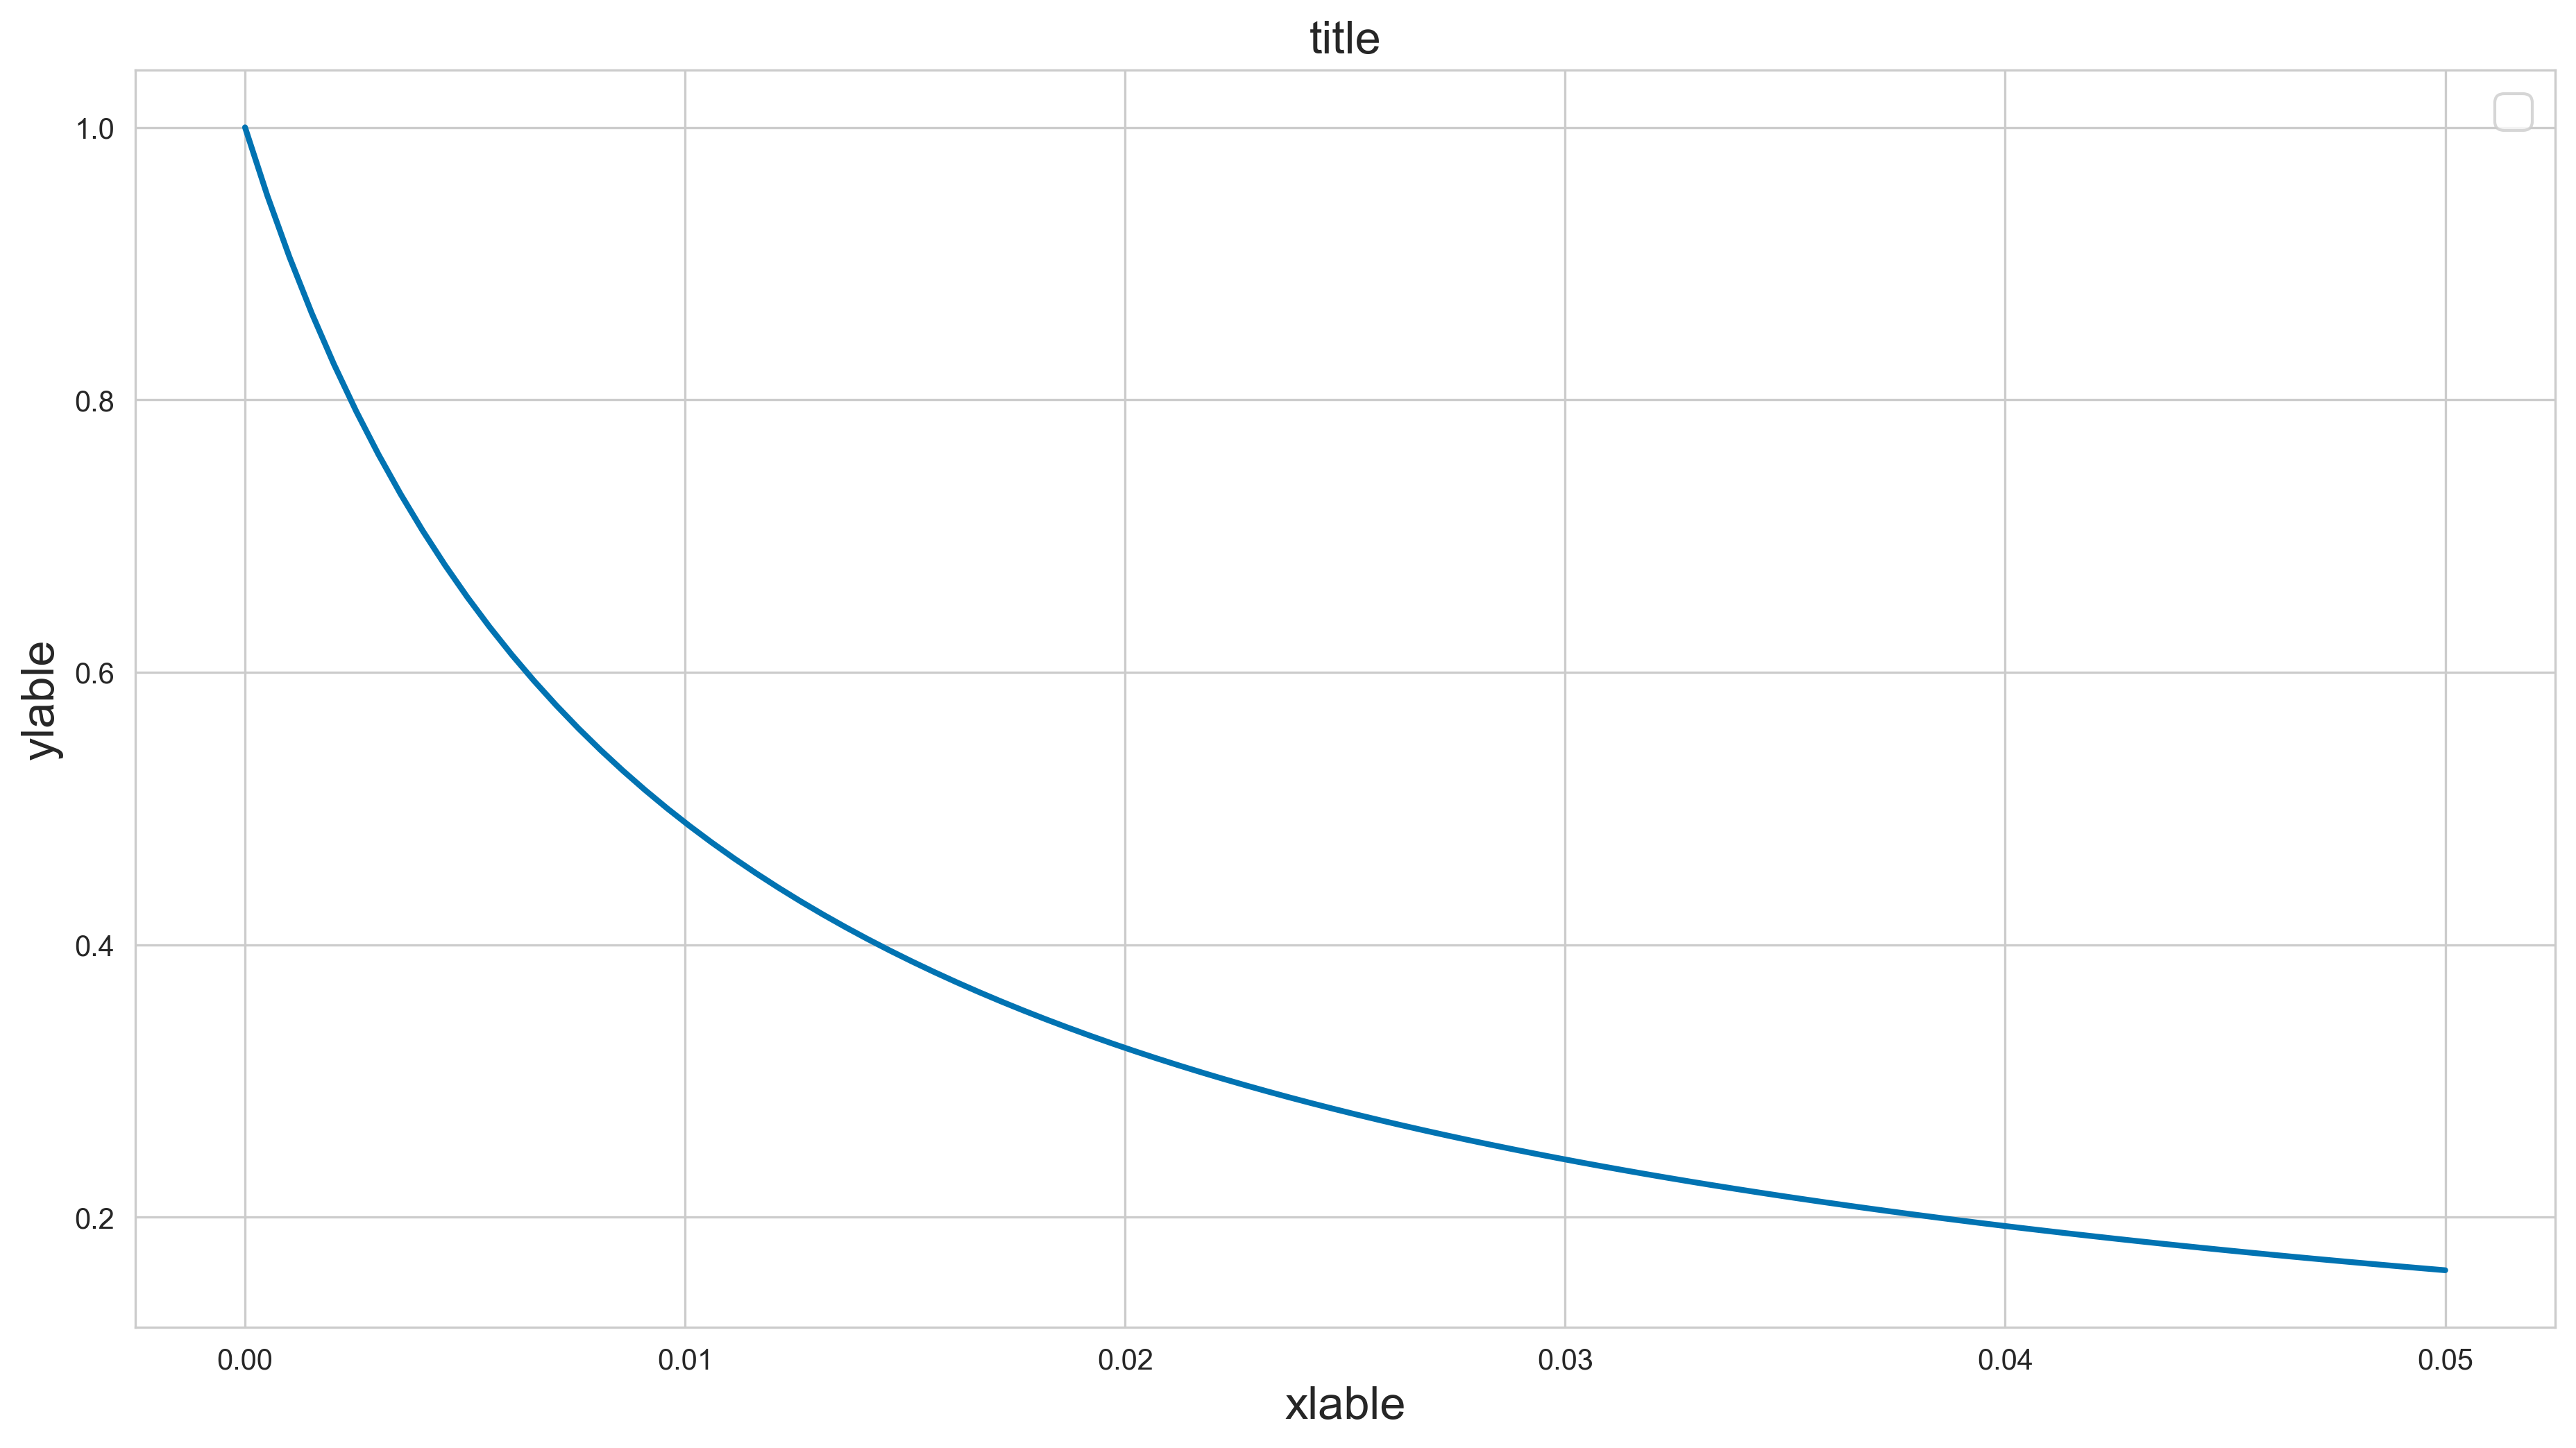

In [50]:

draw_plot(fp_space, 
          compute_posterior(test=1, fp=fp_space),
          title='title',
          xlabel='xlable',
          ylabel='ylable')

### Часть II: О линейной регрессии

In [9]:
data = pd.read_csv('owid-covid-data.csv')

In [10]:
russia = data[(data.location == 'Russia') & (data.date >= '2020-03-03')].set_index('date')[['total_cases', 'new_cases']]

In [11]:
russia.head()

,total_cases,new_cases
date,,
2020-03-03,3.0,0.0
2020-03-04,3.0,0.0
2020-03-05,4.0,1.0
2020-03-06,13.0,9.0
2020-03-07,13.0,0.0


In [12]:
russia.columns

Index(['total_cases', 'new_cases'], dtype='object')

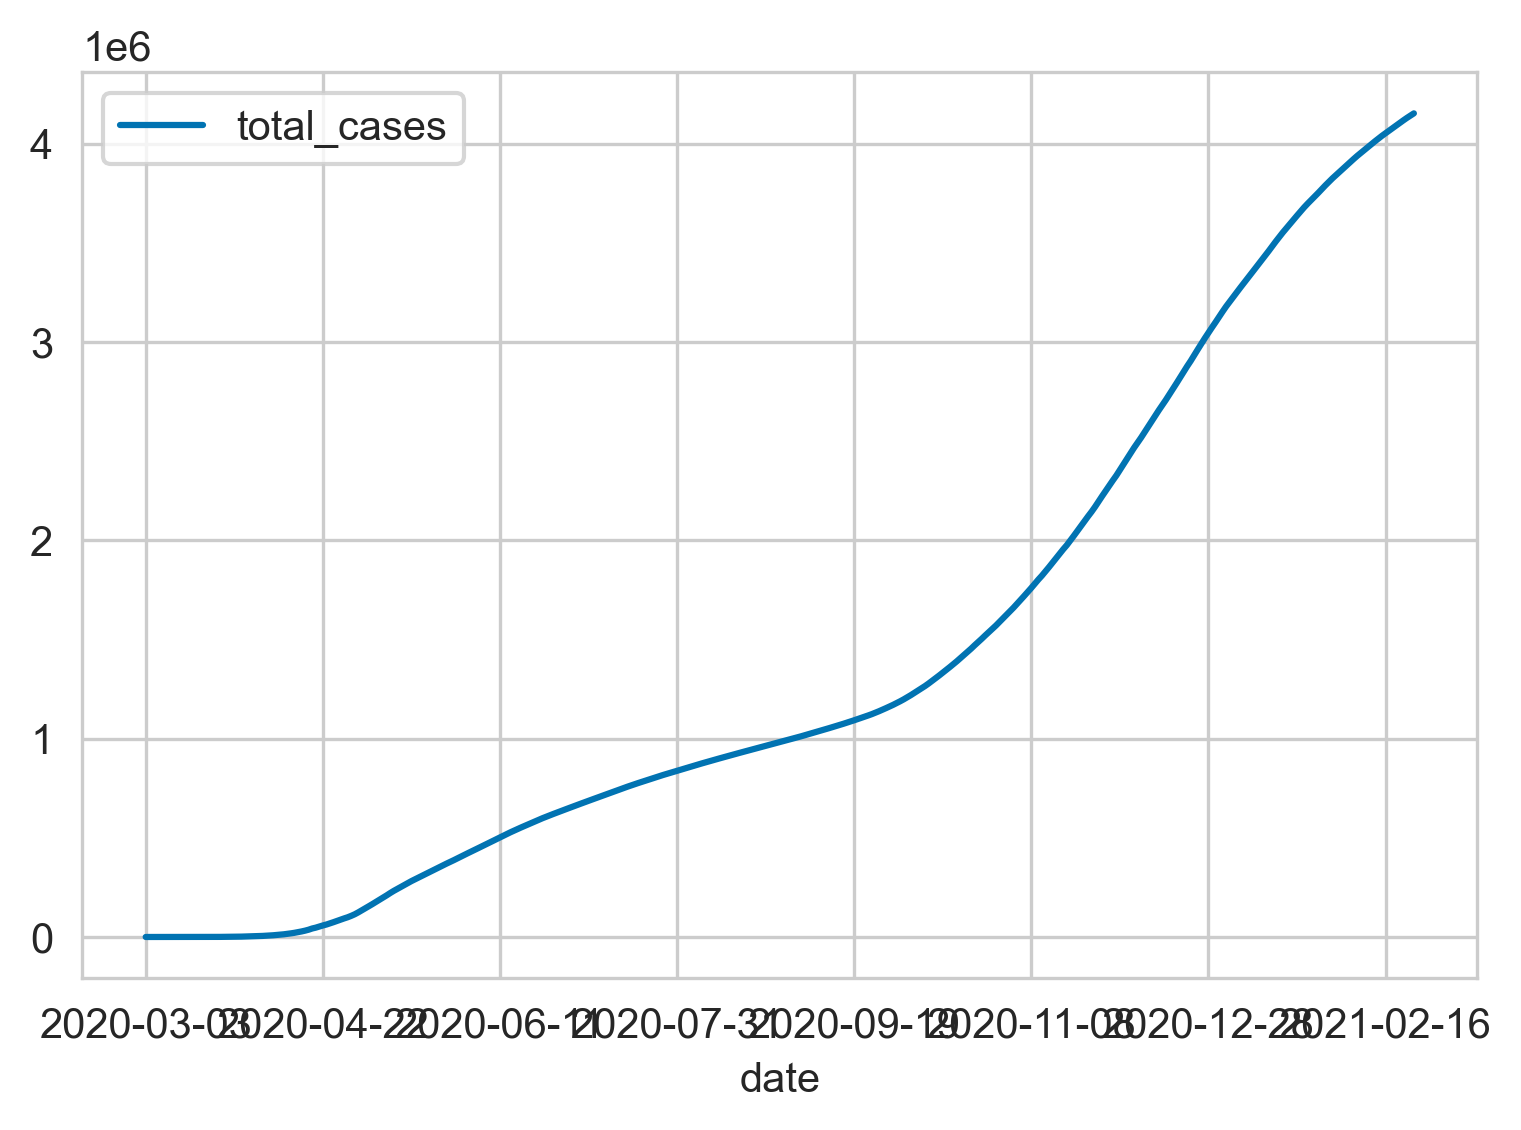

In [13]:
russia[['total_cases']].plot.line();

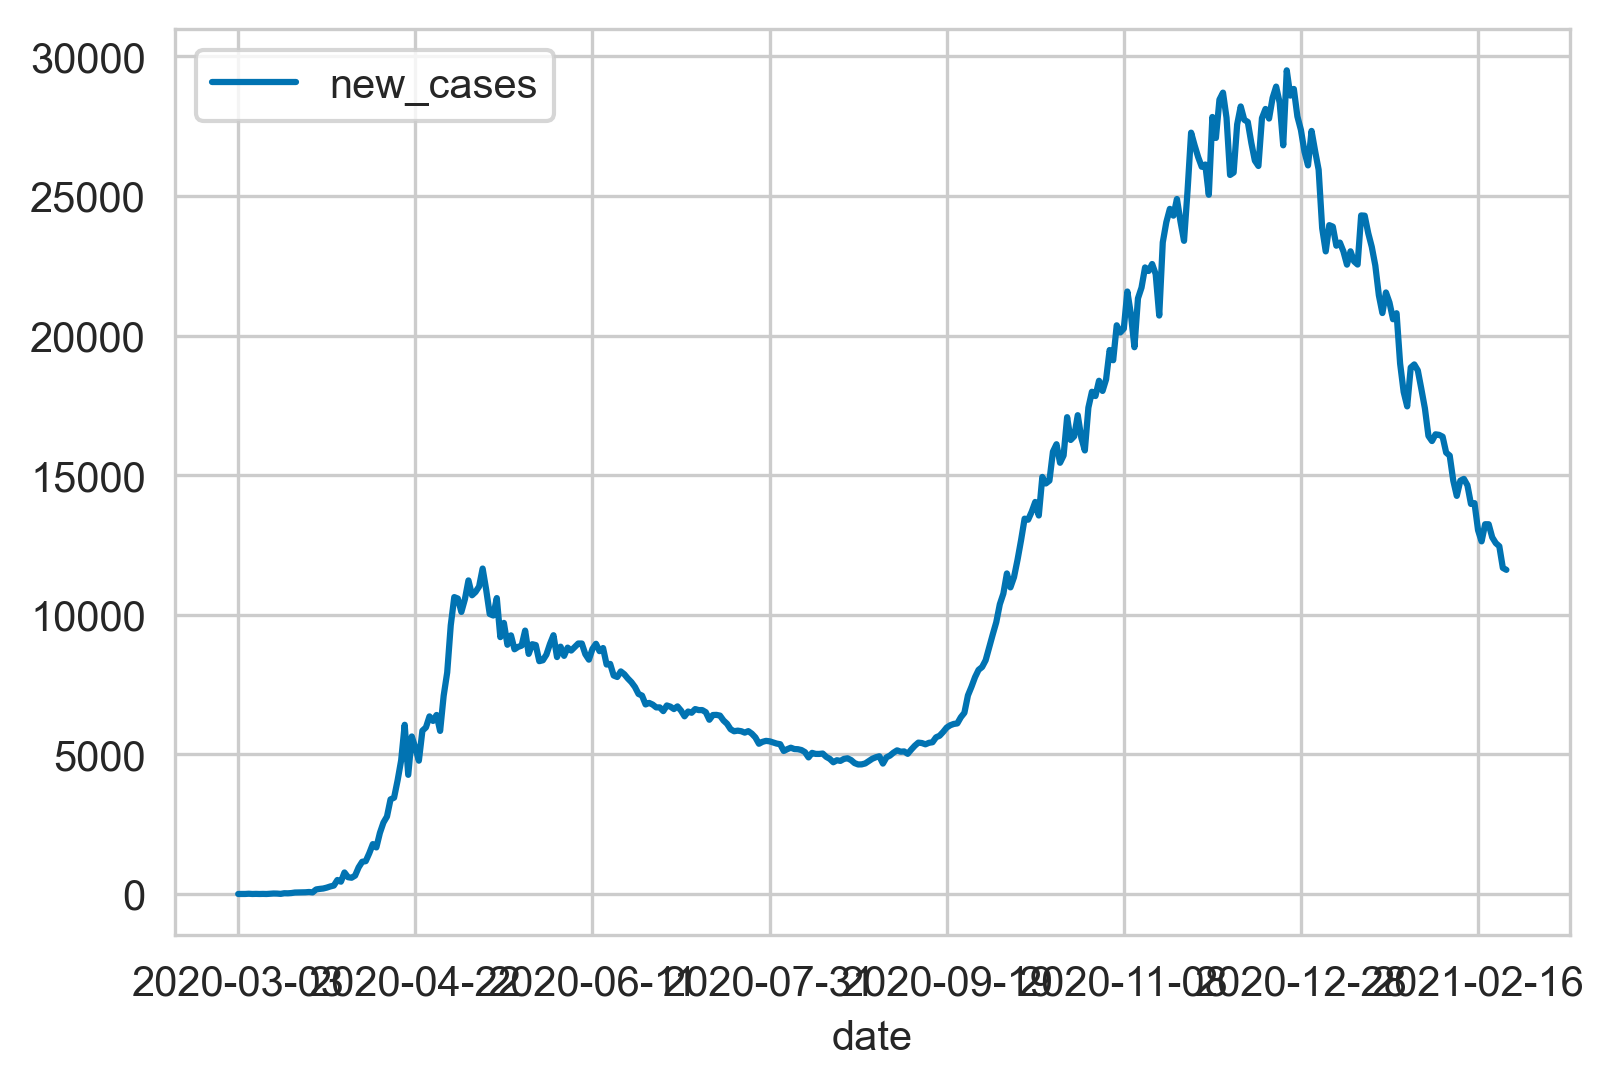

In [14]:
russia[['new_cases']].plot.line();

In [1]:
1 / 10_000

0.0001